<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/PlantVillageDataSet/Test_experiments/plantVillageDenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import Model,load_model
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/shared dataset platVillage/PlantVillage.tar.gz' 'PlantVillage.tar.gz'

In [ ]:
!tar -xf PlantVillage.tar.gz

In [ ]:
trainPath = '/content/PlantVillage/train'
lists = os.listdir(trainPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(trainPath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
train_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(train_df)


                                                    path       label
0      Strawberry___Leaf_scorch/1a01bc1f-7c24-41ba-a5...  Strawberry
1      Strawberry___Leaf_scorch/e1118fe9-cddc-4ac4-a2...  Strawberry
2      Strawberry___Leaf_scorch/1b616826-e312-46b9-99...  Strawberry
3      Strawberry___Leaf_scorch/99ac9cd2-8c79-4f36-b7...  Strawberry
4      Strawberry___Leaf_scorch/08d4f54d-2676-4ce4-8f...  Strawberry
...                                                  ...         ...
43439  Peach___Bacterial_spot/10db8907-e305-4623-943a...       Peach
43440  Peach___Bacterial_spot/80d6ae13-e0d2-4ad6-9b7f...       Peach
43441  Peach___Bacterial_spot/ed3a081e-a497-43d7-8b6f...       Peach
43442  Peach___Bacterial_spot/dfbdce65-39f2-4eda-8989...       Peach
43443  Peach___Bacterial_spot/c664a6bf-dbd7-4394-9a29...       Peach

[43444 rows x 2 columns]


In [ ]:
validationPath = '/content/PlantVillage/val'
lists = os.listdir(validationPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(validationPath +"/"+folder)
    if(folder != 'background'): 
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
    

validation_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(validation_df)


                                                    path       label
0      Strawberry___Leaf_scorch/65e5f561-70cd-4282-98...  Strawberry
1      Strawberry___Leaf_scorch/b4087a7d-dc29-482f-9b...  Strawberry
2      Strawberry___Leaf_scorch/71084f02-55a0-4b60-9a...  Strawberry
3      Strawberry___Leaf_scorch/301e75f8-a15d-4b41-91...  Strawberry
4      Strawberry___Leaf_scorch/7c2952f9-1801-4c11-92...  Strawberry
...                                                  ...         ...
10856  Peach___Bacterial_spot/775f9dde-9d3f-4649-8964...       Peach
10857  Peach___Bacterial_spot/16a68d47-311a-4e64-8ac0...       Peach
10858  Peach___Bacterial_spot/aba9c798-5872-4271-92c1...       Peach
10859  Peach___Bacterial_spot/83e3b0c6-43d6-40f2-81fb...       Peach
10860  Peach___Bacterial_spot/284dc921-9aa8-4e68-9b02...       Peach

[10861 rows x 2 columns]


In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/train/',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/val/',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 43444 validated image filenames belonging to 14 classes.
Found 10861 validated image filenames belonging to 14 classes.


In [ ]:
print(train_generator.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry_(including_sour)': 2, 'Corn_(maize)': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper,_bell': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}


In [ ]:
class_number=14
def build_model_graph(class_number= class_number):
  base_model = DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3))
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dropout(0.3)(x)
  x= Dense(256,activation='relu')(x)
  predictions=Dense(class_number,activation='softmax')(x)
  model=Model(base_model.input,predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.687516 to fit



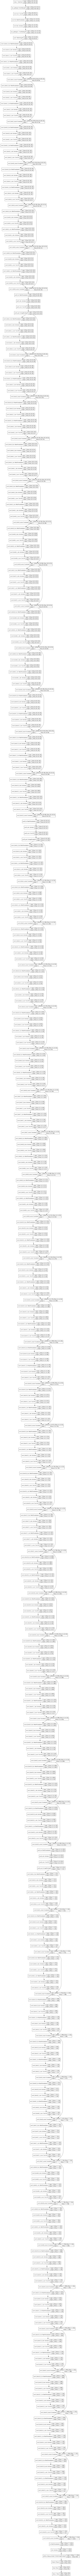

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
1358/1358 [==============================] - 559s 380ms/step - loss: 0.1281 - accuracy: 0.9652 - val_loss: 0.0077 - val_accuracy: 0.9980
Epoch 2/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.0079 - val_accuracy: 0.9978
Epoch 3/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 4/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 5/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 6/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 7/15
1358/1358 [==============================] - 510s 376ms/step - loss: 0.0022 - accuracy: 0.9994 - val_

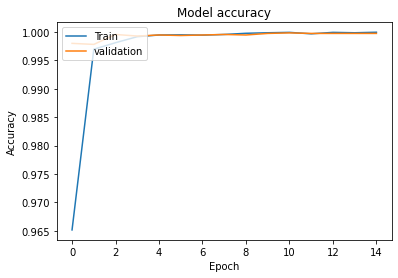

In [ ]:
 import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show() 

In [ ]:
hist = pd.DataFrame(hist.history) 

In [ ]:
DenseNetArch = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/DensNetArch'
os.mkdir(DenseNetArch) 

In [ ]:
hist_csv_file = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/DensNetArch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
target_dir = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/DensNetArch'
architecture_name = "DensNetArch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')